<a href="https://colab.research.google.com/github/chihhui5/Hands_On_PyTorch-TensorFlow/blob/main/W2_CNN_%26_CIFAR_10_classification/W2_CNN_%26_CIFAR_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Step 1. import necessary kit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
#Step 2. check GPU states
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda:0


In [ ]:
#Step 3. Dataset& Data importer

#Define data transform
#A library from torchvision: conbined transformed images
transform = transforms.Compose([

    #Turn original image to Tensor
    #Re-scale pixels[0,255] to float[0.0,1.0]
    #Turn image(Height, Wide, Channel) to Tensor(Channel, Height, Wide)
    transforms.ToTensor(),

    #normalization((mean),(standard deviation))
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#Create training set of CIFAR-10
#Find the "train" dataset from root, if null then download
#Apply transform to every single image
trainset = datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)

#Create a Dataloader to atuo deal with batching and shuffling, etc.
#batch_size 64, then shape of image will be Tensor(64 image, 3 channel, 32*32 pixels)
#Why shuffle? To avoid modle from learning irrelated stuffs
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

#Similat to trainset, but for testing
#Why no shuffle? Fixed order enable consistency and reproducibility, and also to compare
testset = datasets.CIFAR10(root='./data', train = False,download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

#10 catagories
classes=('plane','car','bird','cat','deer',
        'dog','frog','horse','ship','truck')

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


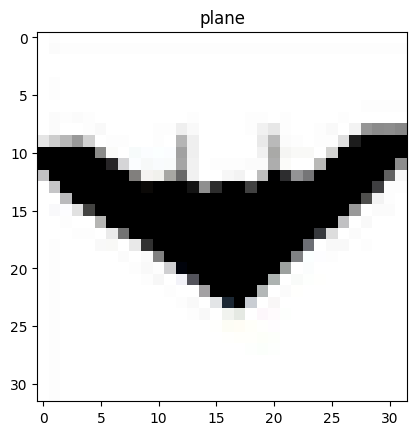

In [ ]:
import numpy as np

#Turn trainloader(DataLoader) to iterator
dataiter = iter(trainloader)
images, labels = next(dataiter)

#Turn Tensor to numpy(H,W,C)
#(0,1,2)->(1,2,0)
plt.imshow(np.transpose(images[0].numpy(), (1,2,0)))

#Get the 1st label
plt.title(classes[labels[0]])
plt.show()

In [ ]:
#Step 4. define CNN module

#inherit nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        #initialize function of nn.Module
        super(SimpleCNN,self).__init__()

        #first 2D convolutional Layer
        #(3 color in_channel, 32 feature maps out_channel, kernel_size 3*3)
        self.conv1 = nn.Conv2d(3,32,3,padding=1)

        #Max Pooling Layer
        #(Kernel_size 2*2, stride 2: move 2 pixels each time)
        self.pool = nn.MaxPool2d(2,2)

        #2nd convolutional layer
        #(32 in_channel from conv1, 64 feature maps out_channel, kernel_size 3*3 same as conv1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)

        #1st Fully connected layer/Linear layer
        #64*8*8: the number of in_features
        #512: the out_features, that is the neuronal number of fully connected layer
        self.fc1 = nn.Linear(64*8*8,512)

        #2nd fully connected layer
        #512 in_features from fc1
        #10 out_features(10 different catagory)
        self.fc2 = nn.Linear(512,10)

    #define how data pass by these layers
    def forward(self,x):
        # for CIFAR-10, shape of x will originally be [B,3,32,32]
        # after convolution then Relu(Rectified Linear Unit) then pool layer
        #pool will cut size half off
        x = self.pool(F.relu(self.conv1(x))) # [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x))) # [B, 64, 8, 8]

        #reshaping - flatten multi-D feature pictures
        #-1: 請根據批次大小 (B) 和其他維度的大小，自動計算出這個維度應該是多少。
        x = x.view(-1,64*8*8)
        x = F.relu(self.fc1(x)) #in_features [B,4096] #out_features[B,512]
        x = self.fc2(x) #in_features[B,512] #out_features[B,10]
        return x

In [ ]:
#Step 4.define the training parameter and device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Step 5.train model

#Review each epoch 10 times
num_epochs = 10

#For graphs in Step6
train_loss = []
test_acc = []

for epoch in range(num_epochs):

    #Train mode
    #Model keep learning and updating parameter
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        #Make image and label run on GPU
        images, labels = images.to(device), labels.to(device)

        # --- PyTorch 訓練的 5 個核心步驟 ---
        optimizer.zero_grad()      # 1. 梯度歸零
        outputs = model(images)    # 2. 前向傳播
        loss = criterion(outputs, labels) # 3. 計算損失
        loss.backward()            # 4. 反向傳播 (計算梯度)
        optimizer.step()           # 5. 更新參數
        # -----------------------------------

        running_loss += loss.item()

    train_loss.append(running_loss / len(trainloader))

    # Validation Phase
    #Evaluation Mode
    model.eval()
    correct, total = 0, 0

    #No need to track any gradian to save GPU resource
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            #Output:original logits of 10 catagory
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    test_acc.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss[-1]:.4f}, Test Acc: {acc:.2f}%")


Epoch [1/10] - Loss: 1.2751, Test Acc: 63.06%
Epoch [2/10] - Loss: 0.8843, Test Acc: 69.12%
Epoch [3/10] - Loss: 0.6979, Test Acc: 72.27%
Epoch [4/10] - Loss: 0.5321, Test Acc: 72.24%
Epoch [5/10] - Loss: 0.3819, Test Acc: 72.07%
Epoch [6/10] - Loss: 0.2476, Test Acc: 73.09%
Epoch [7/10] - Loss: 0.1533, Test Acc: 73.65%
Epoch [8/10] - Loss: 0.0938, Test Acc: 72.14%
Epoch [9/10] - Loss: 0.0765, Test Acc: 72.13%
Epoch [10/10] - Loss: 0.0675, Test Acc: 72.26%


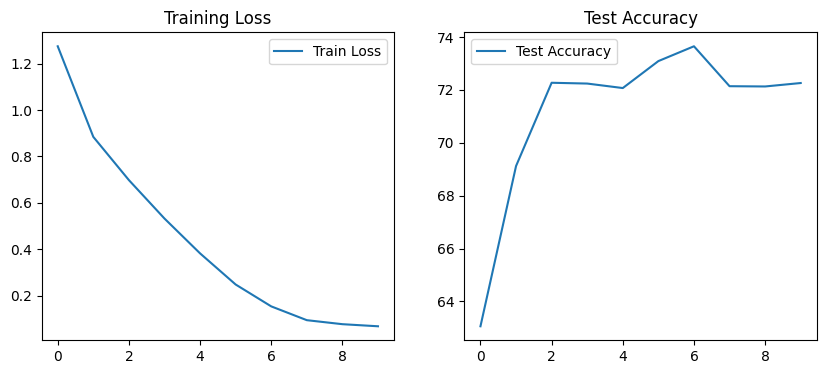

In [ ]:
#Step 6. visualize Loss&Accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_acc, label="Test Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.show()